In [1]:
import embedders

In [107]:
import embedders.gaussian_mixture


pm = embedders.manifolds.ProductManifold(signature=[(1,4),(-1,4)])

X, y = embedders.gaussian_mixture.gaussian_mixture(pm, 1000, cov_scale_means=.1)

/Users/phil/miniforge3/envs/embedders2/lib/python3.10/site-packages/torch/distributions/wishart.py:271: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pdt = embedders.predictors.tree_new.ProductSpaceDT(pm=pm, n_features="d_choose_2", max_depth=3)
pdt.fit(X_train, y_train)

print(f"{pdt.score(X_test, y_test).float().mean().item():.4f}")

0.8150


In [5]:
pdt.__dict__

{'pm': <embedders.manifolds.ProductManifold at 0x34b19a8f0>,
 'max_depth': -1,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_impurity_decrease': 0.0,
 'use_special_dims': False,
 'n_features': 'd_choose_2',
 'ablate_midpoints': False,
 'batch_size': None,
 'batched': True,
 'task': 'classification',
 'criterion': 'gini',
 'nodes': [<embedders.predictors.tree_new.DecisionNode at 0x34b1c94b0>,
 'permutations': None,
 'angle2man': [0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4],
 'special_first': [True,
  True,
  True,
  False,
  False,
  False,
  True,
  True,
  True,
  False,
  False,
  False,
  True,
  True,
  True,
  False,
  False,
  False,
  True,
  True,
  True,
  False,
  False,
  False,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False],
 'angle_dims': [(0, 1),
  (0, 2),
  (0, 3),
  (1, 2),
  (1, 3),
  (2, 3),
  (4, 5),
  (4, 6),
  (4, 7),
  (5

In [6]:
pdt.nodes[0].__dict__

{'value': None,
 'probs': None,
 'feature': 18,
 'theta': 1.0558565855026245,
 'left': <embedders.predictors.tree_new.DecisionNode at 0x357dcb0d0>,
 'right': <embedders.predictors.tree_new.DecisionNode at 0x357dc8970>}

In [7]:
pdt.angle_dims[16]

(9, 11)

In [ ]:
pdt.angle_dims

[(0, 1),
 (0, 2),
 (0, 3),
 (1, 2),
 (1, 3),
 (2, 3),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 6),
 (5, 7),
 (6, 7),
 (8, 9),
 (8, 10),
 (8, 11),
 (9, 10),
 (9, 11),
 (10, 11),
 (12, 13),
 (12, 14),
 (12, 15),
 (13, 14),
 (13, 15),
 (14, 15),
 (None, 16),
 (None, 17),
 (None, 18),
 (16, 17),
 (16, 18),
 (17, 18)]

In [ ]:
X.shape

torch.Size([1000, 19])

(-19592.5, 147.62948608398438)

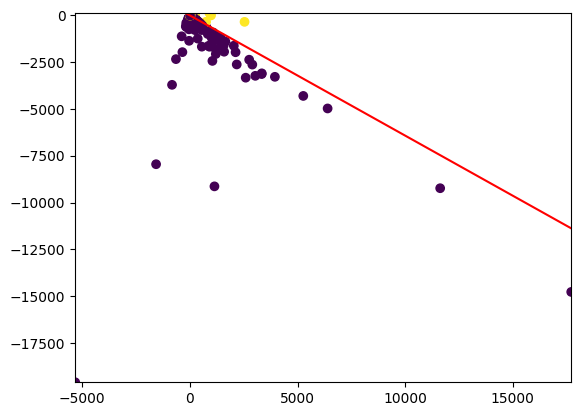

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(X[:, 9].numpy(), X[:, 11].numpy(), c=y)

# plot decision boundary
theta = 2.141489028930664
c = np.cos(theta)
s = np.sin(theta)
plt.plot([-s * 1e10, s * 1e10], [-c * 1e10, c * 1e10], "r-")

# put boundaries back
plt.xlim(X[:, 9].min(), X[:, 9].max())
plt.ylim(X[:, 11].min(), X[:, 11].max())

In [ ]:
pm.dim2man

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 2,
 9: 2,
 10: 2,
 11: 2,
 12: 3,
 13: 3,
 14: 3,
 15: 3,
 16: 4,
 17: 4,
 18: 4}

In [22]:
pdt.nodes[0].__dict__

{'value': None,
 'probs': None,
 'feature': 18,
 'theta': 1.0558565855026245,
 'left': <embedders.predictors.tree_new.DecisionNode at 0x357dcb0d0>,
 'right': <embedders.predictors.tree_new.DecisionNode at 0x357dc8970>}

In [109]:
# This code will traverse the decision tree level by level and do the following:
# 1. Store a mask for whether data points are "live" or not, i.e. whether they were thrown out in previous levels
# 2. Get projection dimensions (pdt.angle_dims[feature])
# 3. Get the threshold
# 4. Store the (mask, dim1, dim2, threshold) tuple in a list
import torch
from embedders.predictors.tree_new import _angular_greater
import matplotlib.pyplot as plt

angles, _, _, comparisons = pdt._preprocess(X, y)

levels = []
to_visit = [(pdt.nodes[0], torch.ones(X.shape[0]).bool())]
while to_visit:
    levels.append(to_visit)
    new_to_visit = []
    l = [
        (node.left, mask & _angular_greater(angles[:, node.feature], torch.tensor(node.theta)).flatten())
        for node, mask in to_visit
        if node.left is not None
    ]
    r = [
        (node.right, mask & ~_angular_greater(angles[:, node.feature], torch.tensor(node.theta)).flatten())
        for node, mask in to_visit
        if node.right is not None
    ]
    to_visit = l + r

print([len(l) for l in levels])

[1, 2, 4, 8]


axis off
axis off
axis off
axis off
axis off


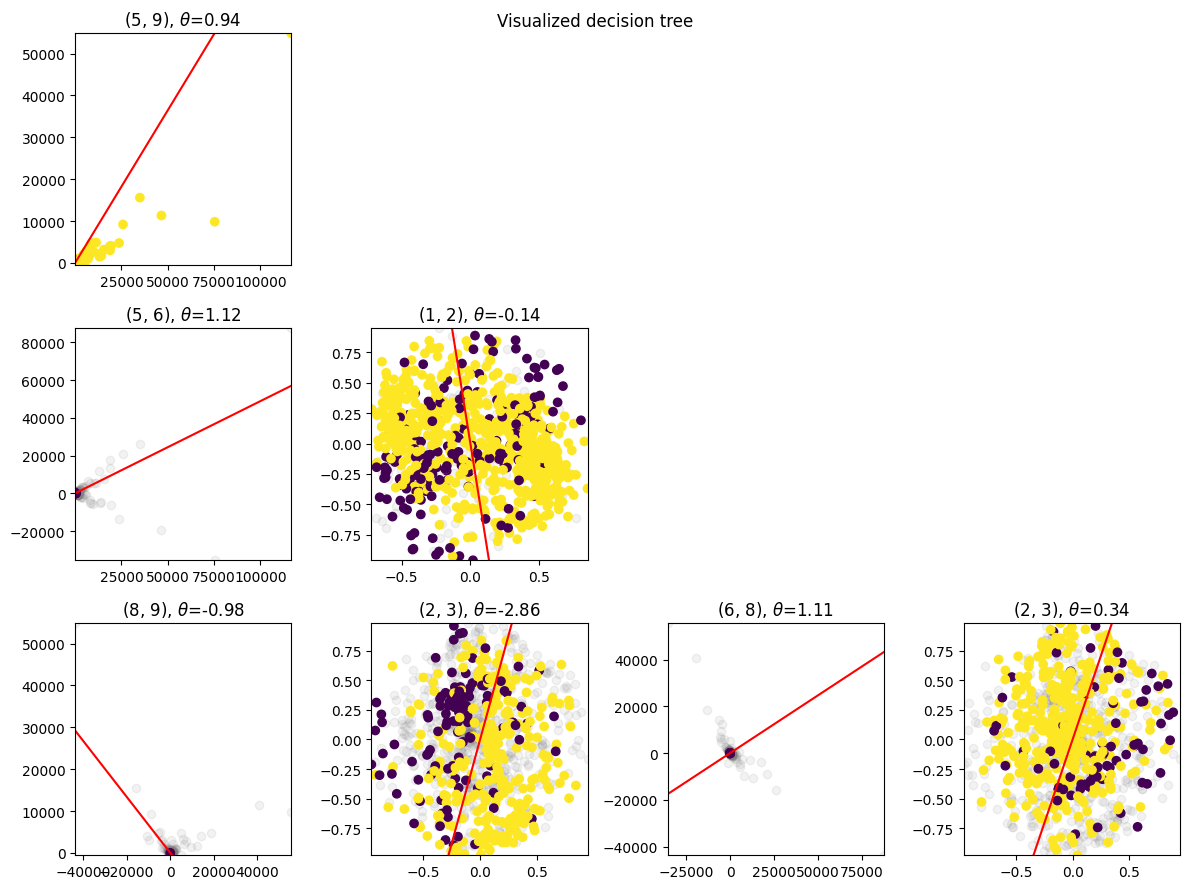

In [115]:
# Plot
import numpy as np

rows = len(levels) - 1  # Since final levels are homogeneous
cols = max(len(l) for l in levels[:-1])
fig, axs = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

for i, level in enumerate(levels[:-1]):
    # for j, (node, mask) in enumerate(level):
    for j in range(cols):
        if j >= len(level):
            print("axis off")
            axs[i, j].axis("off")
            continue
        node, mask = level[j]
        
        if node.feature is None:
            continue
        
        # Plot points
        dim1, dim2 = pdt.angle_dims[node.feature]
        if dim1 is not None:
            axs[i, j].scatter(X[~mask, dim1].numpy(), X[~mask, dim2].numpy(), c="grey", alpha=0.1)
            axs[i, j].scatter(X[mask, dim1].numpy(), X[mask, dim2].numpy(), c=y[mask])
        else:
            axs[i, j].scatter(np.ones((~mask).sum()), X[~mask, dim2].numpy(), c="grey", alpha=0.1)
            axs[i, j].scatter(np.ones(mask.sum()), X[mask, dim2].numpy(), c=y[mask])

        # Plot line
        c = np.cos(node.theta)
        s = np.sin(node.theta)
        axs[i, j].plot([-s * 1e10, s * 1e10], [-c * 1e10, c * 1e10], "r-")

        # Put boundaries back
        axs[i, j].set_xlim(X[:, dim1].min(), X[:, dim1].max())
        axs[i, j].set_ylim(X[:, dim2].min(), X[:, dim2].max())

        # Title is split
        axs[i, j].set_title(f"({dim1}, {dim2}), $\\theta$={node.theta:.2f}")

plt.tight_layout()
plt.suptitle("Visualized decision tree")
plt.savefig("decision_tree_visualization.pdf")

In [89]:
(~mask).sum()

tensor(957)

In [90]:
X[~mask, dim2].shape

torch.Size([957, 1, 8])

In [91]:
dim2